In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from WindPy import w
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

## 获取起始日期

In [3]:
today = datetime.datetime.today()

In [4]:
today.strftime('%Y-%m-%d')

'2019-04-08'

In [5]:
start_date = today - datetime.timedelta(365) # 最近1年

In [6]:
start_date.strftime('%Y-%m-%d')

'2018-04-08'

## 获取数据

In [7]:
df = pd.read_excel(u'../data/资产与宏观数据.xlsx')

In [8]:
df

,Variables,Name,Assets
0,M0001385,M2同比,000300.SH
1,M0001383,M1同比,000905.SH
2,M0000545,工业增加值同比,881001.WI
3,M5525763,社融同比,CBA00602.CS
4,M0017128,PMI新订单,CBA02002.CS
5,M0000605,进出口同比,AU9999.SGE
6,M0001428,社消同比,HSI.HI


In [9]:
var2name = {k: v for k, v in zip(df['Variables'], df['Name'])}

In [10]:
data = w.wsd(df['Assets'].tolist()[:7], 'close', start_date, today)

In [11]:
price = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=data.Codes)
price.index = pd.to_datetime(price.index)

In [12]:
price.tail()

,000300.SH,000905.SH,881001.WI,CBA00602.CS,CBA02002.CS,AU9999.SGE,HSI.HI
2019-04-01,3973.9280,5757.8379,4375.6531,118.4474,79.8626,282.00,29562.02
2019-04-02,3971.2852,5775.5497,4385.7786,118.3174,79.7864,281.51,29624.67
2019-04-03,4022.1566,5836.0369,4436.8796,117.8793,79.7436,282.05,29986.39
2019-04-04,4062.2309,5871.5575,4470.6075,117.7296,79.6849,282.71,29936.32
2019-04-08,4062.2309,5871.5575,4470.6075,117.7296,79.6849,282.71,29936.32


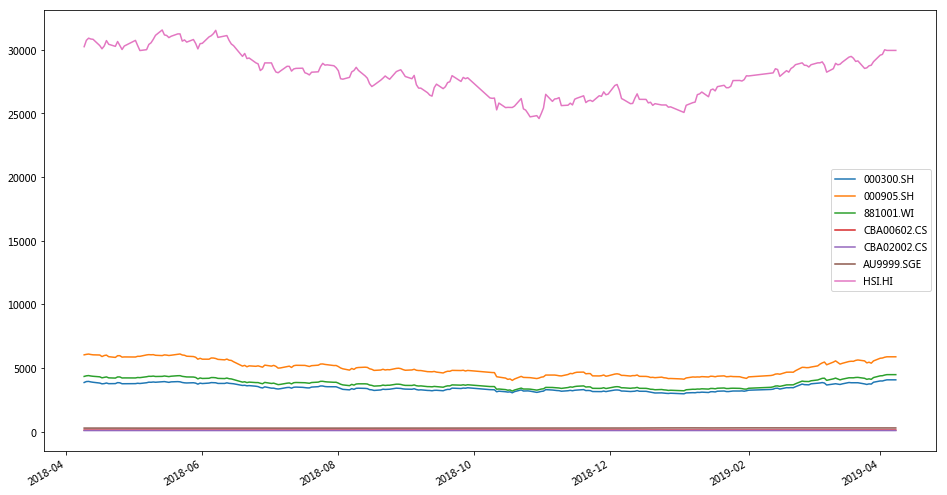

In [13]:
price.plot(figsize=(16, 9))

In [14]:
macro_variables = [x for x in df['Variables'] if str(x).find('.') == -1 and str(x) != 'nan']

In [15]:
macro_variables

[u'M0001385',
 u'M0001383',
 u'M0000545',
 u'M5525763',
 u'M0017128',
 u'M0000605',
 u'M0001428']

In [16]:
data = w.edb(macro_variables, start_date, today)

In [17]:
macro_df = pd.DataFrame(np.array(data.Data).T, index=data.Times, columns=[var2name[x] for x in macro_variables])

In [18]:
macro_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
2018-04-30,8.3,7.2,7.000000,11.886410,52.9,16.50,9.400000
2018-05-31,8.3,6.0,6.800000,11.591320,53.8,18.19,8.500000
2018-06-30,8.0,6.6,6.000000,11.101210,53.2,12.06,9.000000
2018-07-31,8.5,5.1,6.000000,10.840980,52.3,18.26,8.800000
2018-08-31,8.2,3.9,6.100000,10.802550,52.2,14.50,9.000000
2018-09-30,8.3,4.0,5.800000,10.575280,52.0,14.12,9.200000
2018-10-31,8.0,2.7,5.900000,10.224710,50.8,17.00,8.600000
2018-11-30,8.0,1.5,5.400000,9.873883,50.4,3.44,8.100000
2018-12-31,8.1,1.5,5.700000,9.776316,49.7,-5.91,8.160814
2019-01-31,8.4,0.4,6.797753,10.416816,49.6,4.10,NaN


In [19]:
macro_nav = (1+macro_df.pct_change()).cumprod()
macro_nav.iloc[0] = 1

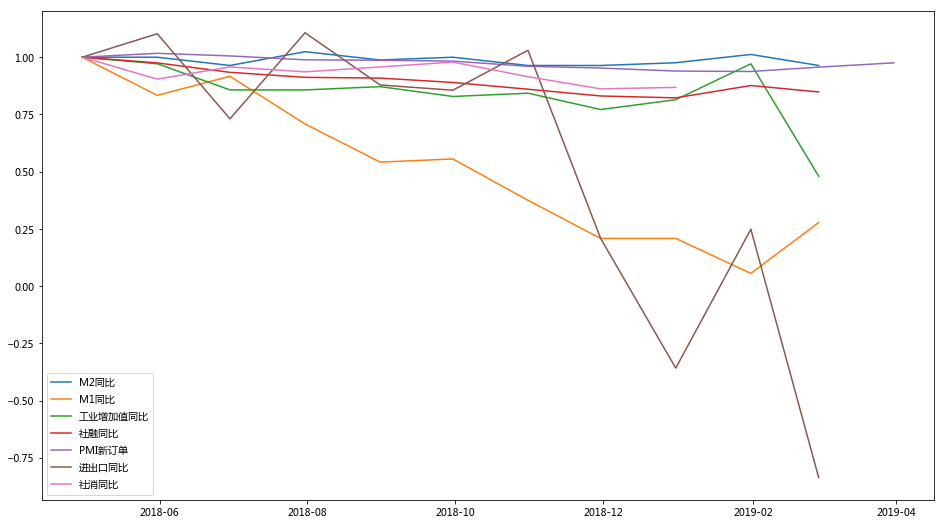

In [20]:
macro_nav.plot(figsize=(16, 9))

In [21]:
macro_df.to_excel('../data/macro_nav.xlsx')

In [22]:
ret_df = pd.DataFrame()

In [23]:
ret_df[u'成长股'] = price['000905.SH'].pct_change()
ret_df[u'价值股'] = price['000300.SH'].pct_change()
ret_df[u'港股'] = price['HSI.HI'].pct_change()
ret_df[u'黄金'] = price['AU9999.SGE'].pct_change()
ret_df[u'国债'] = price['CBA00602.CS'].pct_change()
ret_df[u'信用债'] = price['CBA02002.CS'].pct_change()

## 生成EWMA相关性矩阵

In [24]:
cor_df = pd.DataFrame(index= ret_df.columns, columns=macro_df.columns.tolist())

In [25]:
for asset in cor_df.index:
    for var in cor_df.columns:
        if var in macro_df.columns:
            s, t = (1+ret_df[asset]).cumprod().resample('M').last(), (1+macro_df[var].pct_change()).cumprod()
            corr = s.ewm(alpha=0.02, ignore_na=True, adjust=True).corr(t)
            cor_df.loc[asset, var] = corr[-1]

In [26]:
cor_df

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
成长股,0.2125,0.838965,-0.0154128,0.814745,0.813184,0.337904,0.336562
价值股,0.197729,0.652277,-0.197432,0.699752,0.632817,0.157186,0.244839
港股,0.415208,0.596964,0.0813507,0.787286,0.675596,0.184036,0.305705
黄金,-0.181084,-0.794268,-0.362138,-0.630554,-0.775049,-0.823059,-0.854936
国债,-0.127761,-0.79025,-0.354842,-0.668246,-0.722242,-0.829645,-0.827385
信用债,-0.123907,-0.939182,-0.453779,-0.780791,-0.822155,-0.791454,-0.754624


In [27]:
cor_df.to_excel('../data/macro_ewma_cor.xlsx')

In [28]:
trend = {}
for var in cor_df.columns:
    if var in macro_df.columns:
        t = macro_df[var]
    ret = t.pct_change()
    up, down = ret[ret > 0].sum(), -ret[ret < 0].sum()
    smooth = 1e-2
    if up > down:
        trend[var] = (up + smooth) / (down + smooth)
    else:
        trend[var] = -(down + smooth) / (up + smooth)

In [29]:
for k, v in trend.iteritems():
    print k, v

PMI新订单 -1.35447620710308
M2同比 -1.230720887883993
工业增加值同比 -2.724715258176337
社融同比 -3.1068988832716515
进出口同比 -12.227030808592307
M1同比 1.9307279313492896
社消同比 -1.9933259993595536


In [30]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [31]:
board = pd.DataFrame(index=cor_df.index, columns=cor_df.columns)
for var in cor_df.columns:
#     print var
    x = cor_df[var] * trend[var]
    board[var] = sigmoid(x.astype(np.float32))

In [32]:
trend_df = pd.DataFrame(trend, index=[u'变量趋势'])

In [33]:
board = trend_df.append(board)

In [34]:
board = board[cor_df.columns]

In [35]:
board

,M2同比,M1同比,工业增加值同比,社融同比,PMI新订单,进出口同比,社消同比
变量趋势,-1.230721,1.930728,-2.724715,-3.106899,-1.354476,-12.227031,-1.993326
成长股,0.434988,0.834769,0.510497,0.073691,0.249470,0.015804,0.338300
价值股,0.439461,0.778918,0.631335,0.102104,0.297938,0.127647,0.380354
港股,0.374958,0.759981,0.444811,0.079730,0.285962,0.095331,0.352203
黄金,0.555487,0.177480,0.728440,0.876432,0.740734,0.999957,0.846078
国债,0.539229,0.178615,0.724490,0.888566,0.726763,0.999961,0.838789
信用债,0.538050,0.140239,0.774940,0.918776,0.752798,0.999937,0.818202


In [36]:
board.to_excel('../data/macro_dashboard.xlsx')